# TEXT SUMMARIZATION

# Problem Statement

Customer reviews can be lengthy and detailed. Manually analysing these reviews, as you might guess, takes a long time. This is where Natural Language Processing's application can be put to use to develop a short summary for lengthy reviews.

Our objective here is to generate a summary for the **"Amazon Fine Food reviews"** using the **abstraction-based** and as well as **extraction-based** text summarization approaches.

## 1. Understanding Text Summarization

**Text summarization** is a Natural Language Processing application which produces short and meaningful summary of a lengthy paragraph thereby helping us to understand the essence of the topic in an efficient way.

**Types of Text Summarization**

1. Abstrative Based
2. Extractive Based



In Abstractive based, we generate new sentences from the original text. The sentences generated through abstractive summarization might not be present in the original text.

In Extractive based, we identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary.

## Import the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
import zipfile

# Specify the path to your zip file
zip_path = '/content/drive/MyDrive/ML_SHRUTI/amazon food archive.zip'
extract_path = '/content'

# Open and extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")

Extraction completed!


## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 50,000 reviews to reduce the training time of our model.

In [ ]:
data = pd.read_csv("/content/Reviews.csv")

## Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

## 2. Text Pre-processing

Before we start developing the model, we must first complete some basic preprocessing tasks. Using messy and sloppy text data can be devastating. As a result, in this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

**Let’s define the function for performing the above pre-processing steps**

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [ ]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [ ]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [ ]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

## Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

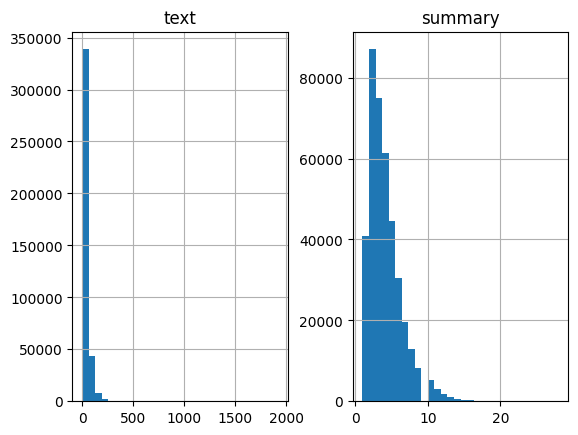

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

**NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.**

Let us understand the proportion of the length of summaries below 8

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9458123944578951


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5597927814286586


Let us fix the maximum length of review to 30

In [ ]:
max_text_len=30
max_summary_len=8

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

In [ ]:
# add the START and END special tokens at the beginning and end of the summary. Here, We have chosen sostok and eostok as START and END tokens

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok


## Train-Test Split and Prepare the Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 68.03323494041761
Total Coverage of rare words: 1.4416020340809668


In [ ]:
print(cnt),print(tot_cnt)

37338
54882


(None, None)

In [ ]:
print(freq),print(tot_freq)

50189
3481474


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

17545

## Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.82090983174345
Total Coverage of rare words: 2.583437288749817


In [ ]:
print(cnt),print(tot_cnt)

15817
20861


(None, None)

In [ ]:
print(freq),print(tot_freq)

25949
1004437


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
#deleting the rows that contain only START and END tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

#Encoder Decoder Model without Attention

In [ ]:
 #Encoder setup without attention
latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# Decoder setup (no attention)
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer for output
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs2 = decoder_dense(decoder_outputs)

# Define the model
basic_model = Model([encoder_inputs, decoder_inputs], decoder_outputs2)

# Compile the model
basic_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
basic_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 30, 100)        │      1,754,500 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │        504,500 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 30, 300),      │        481,200 │ embedding_2[0][0]      │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_3[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_4[0][1],          │
│                           │ 300)]                  │                │ lstm_4[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 5045)     │      1,518,545 │ lstm_5[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,739,945 (18.08 MB)

 Trainable params: 4,739,945 (18.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model training
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history1 = basic_model.fit([x_tr, y_tr[:,:-1]],
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=15,
                    callbacks=[es],
                    batch_size=512,
                    validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
                   )

Epoch 1/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 71s 174ms/step - accuracy: 0.5118 - loss: 3.7904 - val_accuracy: 0.5824 - val_loss: 2.8180
Epoch 2/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 64s 173ms/step - accuracy: 0.5868 - loss: 2.7789 - val_accuracy: 0.5973 - val_loss: 2.6408
Epoch 3/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.5988 - loss: 2.6237 - val_accuracy: 0.6073 - val_loss: 2.5155
Epoch 4/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.6079 - loss: 2.4962 - val_accuracy: 0.6131 - val_loss: 2.4222
Epoch 5/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 65s 174ms/step - accuracy: 0.6138 - loss: 2.4054 - val_accuracy: 0.6183 - val_loss: 2.3511
Epoch 6/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.6185 - loss: 2.3284 - val_accuracy: 0.6251 - val_loss: 2.2777
Epoch 7/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.6254 - loss: 2.2476 - val_accuracy: 0.6299 - val_loss: 2.2177
Epoch 8/15
371/371 ━━━━━━━━━━━━━━━━━━━━ 80s 172ms/step - accuracy: 0.6300 - loss: 2

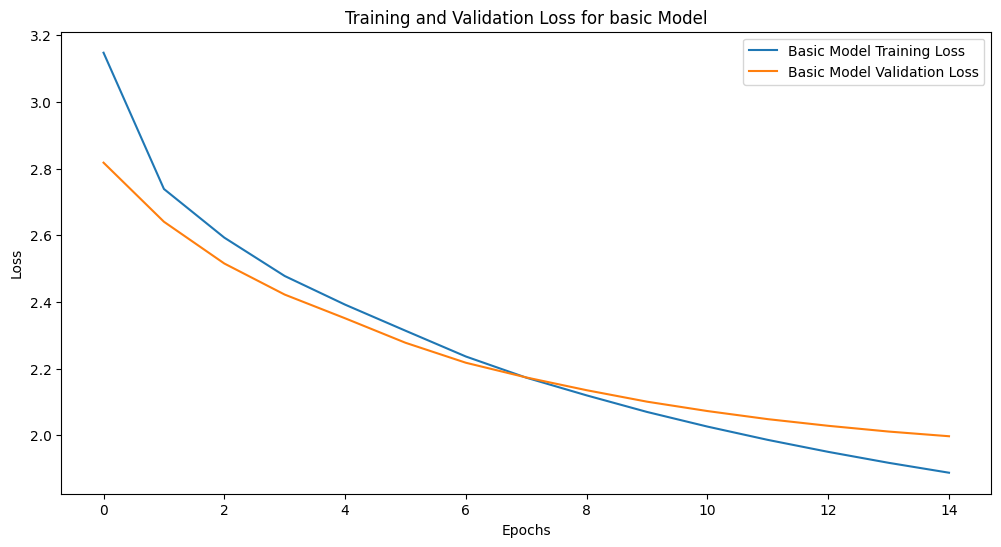

In [ ]:
plt.figure(figsize=(12, 6))

    # Plot for basic model
plt.plot(history1.history['loss'], label='Basic Model Training Loss')
plt.plot(history1.history['val_loss'], label='Basic Model Validation Loss')


plt.title('Training and Validation Loss for basic Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

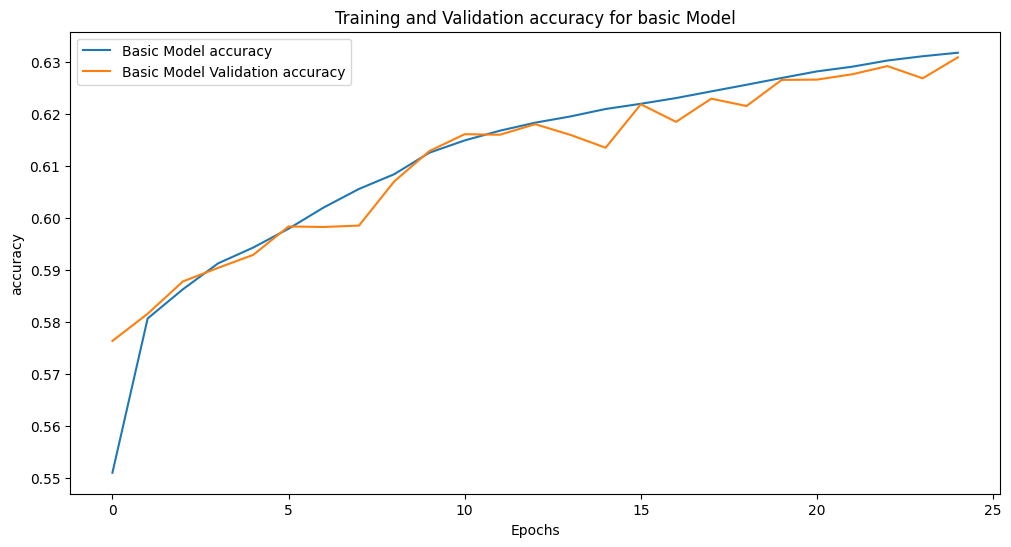

In [ ]:
    plt.figure(figsize=(12, 6))

    # Plot for basic model
    plt.plot(history.history['accuracy'], label='Basic Model accuracy')
    plt.plot(history.history['val_accuracy'], label='Basic Model Validation accuracy')



    plt.title('Training and Validation accuracy for basic Model')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [ ]:
!pip install rouge_score
from rouge_score import rouge_scorer


In [ ]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to convert predictions and references back to text sequences
def sequences_to_text(sequences, tokenizer):
    """Convert sequences of token indices to text."""
    return [" ".join([tokenizer.index_word[idx] for idx in seq if idx > 0]) for seq in sequences]

# Convert predictions to text
y_pred = basic_model.predict([x_val, y_val[:, :-1]])
y_pred_class = np.argmax(y_pred, axis=-1)
predicted_texts = sequences_to_text(y_pred_class, y_tokenizer)

# Convert ground truth to text
reference_texts = sequences_to_text(y_val[:, 1:], y_tokenizer)

# Calculate ROUGE scores for each predicted-reference pair
rouge_scores = []
for pred, ref in zip(predicted_texts, reference_texts):
    score = scorer.score(ref, pred)
    rouge_scores.append(score)

# Aggregate ROUGE scores across all examples
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

print(f"ROUGE-1 F1 Score: {avg_rouge1:.4f}")
print(f"ROUGE-2 F1 Score: {avg_rouge2:.4f}")
print(f"ROUGE-L F1 Score: {avg_rougeL:.4f}")


658/658 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step
ROUGE-1 F1 Score: 0.4282
ROUGE-2 F1 Score: 0.1269
ROUGE-L F1 Score: 0.4259


# **Encoder-Decoder Model with Attention**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class AttentionLayer(Layer):
    """
    Implements Bahdanau attention.
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        self.W_a = self.add_weight(name='W_a',
                                   shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=(input_shape[0][2], 1),
                                   initializer='uniform',
                                   trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            # Compute S.W_a
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            # Compute hj.U_a
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)

            # tanh(S.W_a + hj.U_a)
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            # softmax(V_a . tanh(...))
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing context vector ci using ei """
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)

        # Computing energy outputs
        last_out, e_outputs, _ = K.rnn(energy_step, decoder_out_seq, [fake_state_e])

        # Computing context vectors
        last_out, c_outputs, _ = K.rnn(context_step, e_outputs, [fake_state_c])

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 100)        │      1,754,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 30, 300),      │        481,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │        504,500 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 30, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        481,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 300),    │        180,300 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 30)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 600)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 5045)     │      3,032,045 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,876,145 (30.05 MB)

 Trainable params: 7,876,145 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

Sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

EarlyStopping monitors the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [ ]:
# Define EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)


Fit the model

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=25,
                  callbacks=[es],
                  batch_size=512,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 137s 313ms/step - accuracy: 0.5027 - loss: 3.6884 - val_accuracy: 0.5764 - val_loss: 2.9859
Epoch 2/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 109s 295ms/step - accuracy: 0.5792 - loss: 2.9232 - val_accuracy: 0.5816 - val_loss: 2.8350
Epoch 3/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 143s 297ms/step - accuracy: 0.5847 - loss: 2.8167 - val_accuracy: 0.5878 - val_loss: 2.7553
Epoch 4/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 141s 294ms/step - accuracy: 0.5894 - loss: 2.7224 - val_accuracy: 0.5904 - val_loss: 2.6806
Epoch 5/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 143s 297ms/step - accuracy: 0.5946 - loss: 2.6473 - val_accuracy: 0.5929 - val_loss: 2.6289
Epoch 6/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 141s 293ms/step - accuracy: 0.5966 - loss: 2.6005 - val_accuracy: 0.5984 - val_loss: 2.5775
Epoch 7/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 141s 292ms/step - accuracy: 0.6011 - loss: 2.5498 - val_accuracy: 0.5983 - val_loss: 2.5262
Epoch 8/25
371/371 ━━━━━━━━━━━━━━━━━━━━ 143s 294ms/step - accuracy: 0.6039 -

In [ ]:
# Saving the trained model
model.save('/content/trained_model.h5')

print("Model saved successfully as 'trained_model.h5'")

Model saved successfully as 'trained_model.h5'


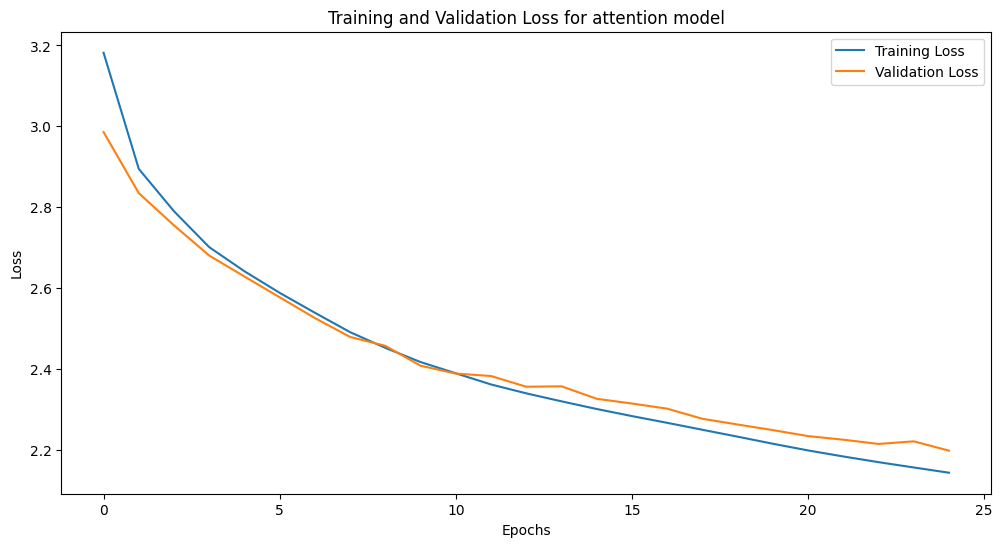

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for attention model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Understanding the Diagnostic plot

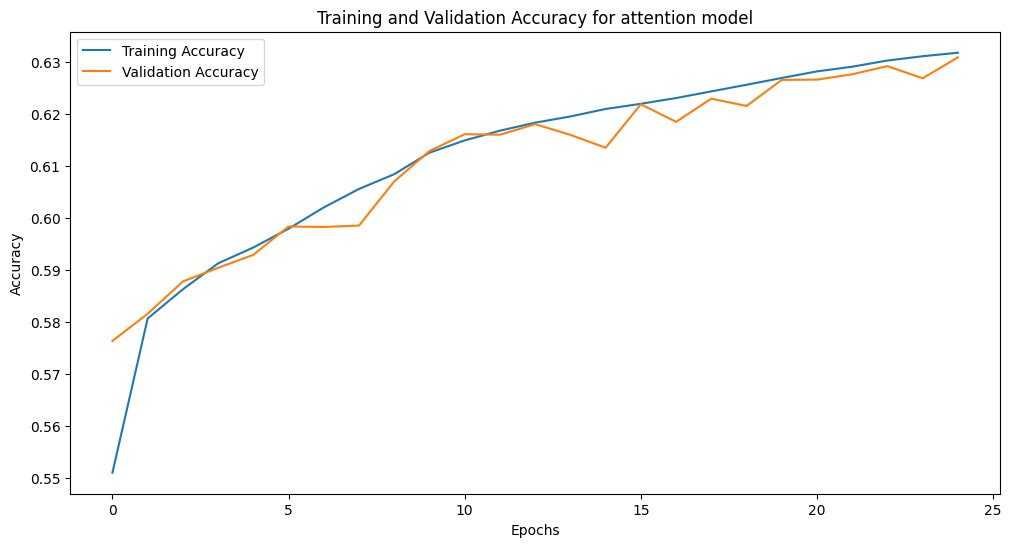

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for attention model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

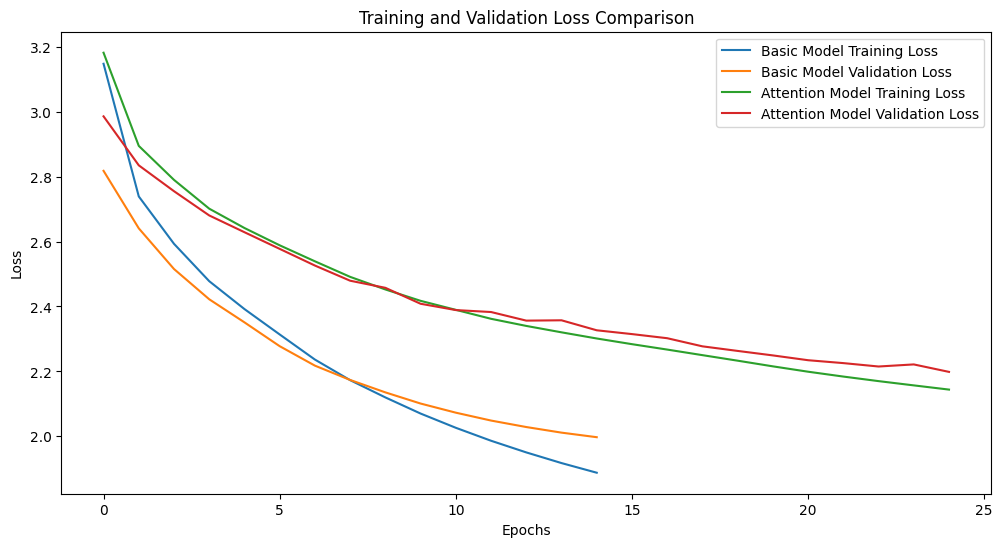

In [ ]:
plt.figure(figsize=(12, 6))

    # Plot for basic model
plt.plot(history1.history['loss'], label='Basic Model Training Loss')
plt.plot(history1.history['val_loss'], label='Basic Model Validation Loss')

    # Plot for attention model
plt.plot(history.history['loss'], label='Attention Model Training Loss')
plt.plot(history.history['val_loss'], label='Attention Model Validation Loss')


plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to convert predictions and references back to text sequences
def sequences_to_text(sequences, tokenizer):
    """Convert sequences of token indices to text."""
    return [" ".join([tokenizer.index_word[idx] for idx in seq if idx > 0]) for seq in sequences]

# Convert predictions to text
y_pred = model.predict([x_val, y_val[:, :-1]])
y_pred_class = np.argmax(y_pred, axis=-1)
predicted_texts = sequences_to_text(y_pred_class, y_tokenizer)

# Convert ground truth to text
reference_texts = sequences_to_text(y_val[:, 1:], y_tokenizer)

# Calculate ROUGE scores for each predicted-reference pair
rouge_scores = []
for pred, ref in zip(predicted_texts, reference_texts):
    score = scorer.score(ref, pred)
    rouge_scores.append(score)

# Aggregate ROUGE scores across all examples
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

print(f"ROUGE-1 F1 Score: {avg_rouge1:.4f}")
print(f"ROUGE-2 F1 Score: {avg_rouge2:.4f}")
print(f"ROUGE-L F1 Score: {avg_rougeL:.4f}")


658/658 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step
ROUGE-1 F1 Score: 0.4025
ROUGE-2 F1 Score: 0.0884
ROUGE-L F1 Score: 0.4010


Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# **## Inference**

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [ ]:
for i in range(0, 10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: easily best peanuts ever waaay better salted cannot stop eating start downside addictive insane amount calories 
Original summary: best peanuts ever 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted summary:  great taste


Review: read ingredients carefully instead reviews fresh garlic great garlic powder keep days alas 
Original summary: wish would it has garlic powder 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted summary:  great product


Review: searched affordable tonic water hansen hands 
Original summary: great taste for the value 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted summary:  great stuff


Review: product full strength 

Finally, Our model is able to generate a meaningful summary based on the context present in the text.

# **Text Summarization using BERT**

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [ ]:
# Load smaller BART model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:

# Preprocess the data
def preprocess_data(texts, summaries, max_input_len=512, max_output_len=128):
    inputs = tokenizer(texts, max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    outputs = tokenizer(summaries, max_length=max_output_len, truncation=True, padding="max_length", return_tensors="pt")
    return inputs.input_ids, outputs.input_ids

In [ ]:
# Convert x_tr and y_tr to lists of strings
x_tr = list(map(str, x_tr))  # Ensure each entry is a string
y_tr = list(map(str, y_tr))
x_val = list(map(str, x_val))
y_val = list(map(str, y_val))

In [ ]:
# Use a subset of the training and validation data
subset_size = 500
x_tr = x_tr[:subset_size]
y_tr = y_tr[:subset_size]
x_val = x_val[:subset_size]
y_val = y_val[:subset_size]

# Re-run preprocessing on the subset
train_inputs, train_labels = preprocess_data(x_tr, y_tr)
val_inputs, val_labels = preprocess_data(x_val, y_val)

In [ ]:
# Convert labels to have padding token set to -100 (required by Hugging Face for loss computation)
train_labels[train_labels == tokenizer.pad_token_id] = -100
val_labels[val_labels == tokenizer.pad_token_id] = -100

In [ ]:
# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1)


In [ ]:
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
epochs=2
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, labels = batch

        with autocast():  # Enable mixed precision
            outputs = model(input_ids=inputs, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1} completed.")


Epoch 1 completed.


In [ ]:
# Evaluate on validation set
model.eval()
generated_summaries = []
true_summaries = []

for batch in val_loader:
    inputs, labels = batch
    outputs = model.generate(inputs, max_length=128, num_beams=4, early_stopping=True)
    generated_summaries.extend([tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs])
    true_summaries.extend([tokenizer.decode(ids, skip_special_tokens=True) for ids in labels])

# Compute ROUGE scores
rouge_scores = calculate_rouge_scores(true_summaries, generated_summaries)

print("ROUGE Scores for BERT Model:")
print(f"ROUGE-1 F1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2 F1: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L F1: {rouge_scores['rougeL']:.4f}")
